<a href="https://colab.research.google.com/github/Requenamar3/Machine-Learning/blob/main/MRCarseats_unusual_observations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

In [24]:
def rse_calculator (y_actual, y_predicted, p):

  rse_value = np.sqrt ( np.sum((y_actual - y_predicted)**2) / (y_actual.size - p -1) )

  return np.round (rse_value, 4)

In [25]:
def adj_r2_calculator (r2_value, n, p):

  adj_r2_value = 1 - (1- r2_value) * ( (n - 1) / (n - p - 1) )

  return np.round (adj_r2_value, 4)

In [26]:
url= "https://raw.githubusercontent.com/Requenamar3/Machine-Learning/refs/heads/main/Carseats.csv"
carseats_df = pd.read_csv(url)

There are three types of unusual observations/cases: outliers, extreme cases, and influential cases.

* Outliers are observations with either an unusually small or large value for the outcome variable.

* Extreme cases are observations whose values for one predictor are either very small or very large compared to the other observations. In a multiple linear regression analysis, it is more accurate to describe an extreme point as an observation whose value in the m-dimensional predictor space (assuming we have m predictors) is either very small or very large relative to the other observations.

* An influential case is either an outlier or an extreme point whose inclusion will substantially alter the coefficient estimations or the predicted values (or both).

The end goal should be to detect the influential observations (which again, could be either outliers, extreme cases, or both).

According to Ronald Hocking in "Methods and Applications of Linear Models":

"Experience indicates that using the __Studentized residuals__ to detect outliers, the __diagonal elements of [the] H [matrix]__ to detect extreme points, and __Cook’s distance__ as a general measure of influence should be adequate." (Hockings, chapter 6, page 196).

In this notebook, we will only focus on outliers and influential cases. But we will NOT use the well-accepted methods mentioned above. We will use simpler methods to detect both outliers and influential cases.

<br>

Run the following command to __import the three functions__ defined in the __'BSS_definitions.ipynb'__ notebook.

Note: The __'BSS_definitions.ipynb'__ notebook does NOT have to be open for us to import their content. Keep it close.

In [27]:
%run "/content/sample_data/bss_definitions.py"

### The Carseats dataset

The outcome variable is Sales: unit sales (in thousands) at each location.



In [28]:
carseats_data_path = "/content/drive/MyDrive/CAP 4631C/Datasets_CAP4631C/Carseats.csv"

In [29]:
carseats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


There are three qualitative predictors. Let's convert them into dummies.

In [30]:
carseats_df_dummies = pd.get_dummies (carseats_df,columns= ['ShelveLoc','Urban','US'], drop_first = True)

In [31]:
carseats_df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales             400 non-null    float64
 1   CompPrice         400 non-null    int64  
 2   Income            400 non-null    int64  
 3   Advertising       400 non-null    int64  
 4   Population        400 non-null    int64  
 5   Price             400 non-null    int64  
 6   Age               400 non-null    int64  
 7   Education         400 non-null    int64  
 8   ShelveLoc_Good    400 non-null    bool   
 9   ShelveLoc_Medium  400 non-null    bool   
 10  Urban_Yes         400 non-null    bool   
 11  US_Yes            400 non-null    bool   
dtypes: bool(4), float64(1), int64(7)
memory usage: 26.7 KB


### Univariate outliers?

Reminder: Outliers are relative to the outcome variable.

In [32]:
carseats_df_dummies['Sales'].describe()

,Sales
count,400.000000
mean,7.496325
std,2.824115
min,0.000000
25%,5.390000
50%,7.490000
75%,9.320000
max,16.270000


In [33]:
# What's the location with no sales?

carseats_df_dummies[carseats_df_dummies['Sales']==0]

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
174,0.0,139,24,0,358,185,79,15,False,True,False,False


In [34]:
# Ten lowest sales

carseats_df_dummies.sort_values (by='Sales').head(10)

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
174,0.00,139,24,0,358,185,79,15,False,True,False,False
106,0.16,102,33,0,217,139,70,18,False,True,False,False
165,0.37,147,58,7,100,191,27,15,False,False,True,True
143,0.53,122,88,7,36,159,28,17,False,False,True,True
57,0.91,93,91,0,22,117,75,11,False,False,True,False
50,1.42,99,32,18,341,108,80,16,False,False,True,True
62,1.82,139,45,0,146,133,77,17,False,False,True,True
203,2.05,131,82,0,132,157,25,14,False,False,True,False
40,2.07,119,98,0,18,126,73,17,False,False,False,False
84,2.23,111,25,0,52,121,43,18,False,False,False,False


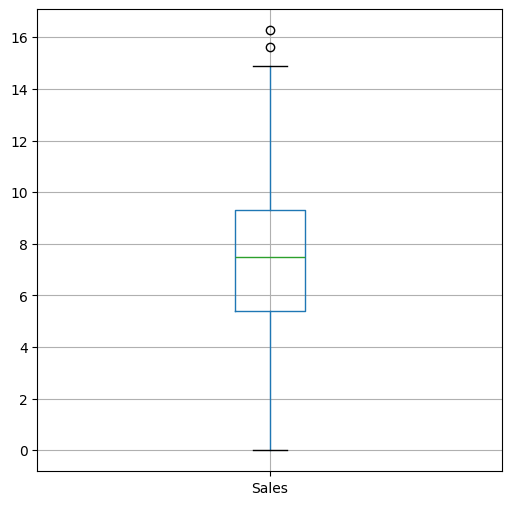

In [35]:
# Box plot of Sales

plt.figure(figsize=(6, 6))
carseats_df_dummies.boxplot(column = 'Sales', vert = True)
plt.show()

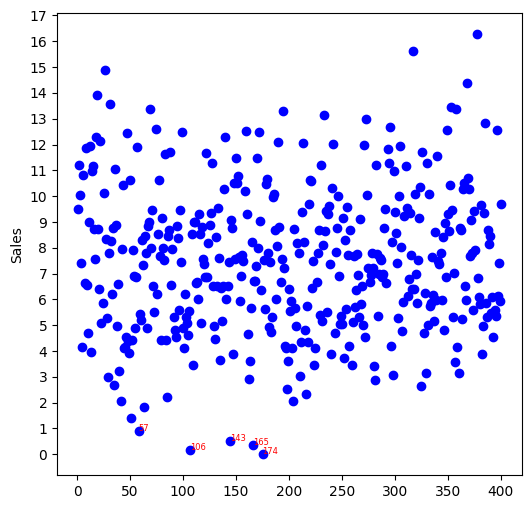

In [36]:
# Plot of Sales

plt.figure(figsize=(6, 6))

plt.scatter(np.arange (1, carseats_df_dummies.shape[0] + 1), carseats_df_dummies['Sales'], c='blue')

for i, sales in enumerate(carseats_df_dummies['Sales']):
    if sales < 1:
        plt.text(i + 1, sales, str(i), fontsize=6, color='red', ha='left')

plt.ylabel("Sales")

plt.yticks(np.arange (0,18))

plt.show()

Thus, the case where Sales = 0 is not an outlier. We can observe that this case is NOT far away from the other observations in a clear way.

### Multivariate outliers?

Are there outlier observations relative to the linear equation that we will obtain to predict sales?

To identify outliers relative to the equation, we will compute and explore the **standardized residuals**.

#### Apply BSS to get a good linear regression equation

Let's change the dummies' data type from Boolean to integer.

In [37]:
carseats_df_dummies = carseats_df_dummies.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [38]:
carseats_df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales             400 non-null    float64
 1   CompPrice         400 non-null    int64  
 2   Income            400 non-null    int64  
 3   Advertising       400 non-null    int64  
 4   Population        400 non-null    int64  
 5   Price             400 non-null    int64  
 6   Age               400 non-null    int64  
 7   Education         400 non-null    int64  
 8   ShelveLoc_Good    400 non-null    int64  
 9   ShelveLoc_Medium  400 non-null    int64  
 10  Urban_Yes         400 non-null    int64  
 11  US_Yes            400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [39]:
X_all_carseats = carseats_df_dummies.drop(['Sales'], axis = 1)

In [40]:
y_carseats = carseats_df_dummies ['Sales']

In [41]:
X_train_car, X_test_car, y_train_car, y_test_car = train_test_split (X_all_carseats, y_carseats, test_size = 0.2, random_state = 1)

In [42]:
bss_cv_results_carseats = my_best_subset_selection_cv (X_train_car, y_train_car, folds = 10)

Cross-validation results for predictors: ['ShelveLoc_Good']
Cross-validation MSE values: [6.30317302 5.28506292 5.5995691  5.96759504 6.5109208  8.26904743
 5.56672374 4.6874147  4.59728435 5.67535691]
Mean cross-validation MSE: 5.8462



/content/sample_data/bss_definitions.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df = pd.concat([out_df, df_iteration], ignore_index=True)


Cross-validation results for predictors: ['Price', 'ShelveLoc_Good']
Cross-validation MSE values: [4.624391   3.06934813 4.45001888 4.54493702 4.39410399 5.4542461
 3.459841   4.40769015 3.59773683 4.75918777]
Mean cross-validation MSE: 4.2762

Cross-validation results for predictors: ['CompPrice', 'Price', 'ShelveLoc_Good']
Cross-validation MSE values: [3.6620587  2.15447126 3.78526721 3.20456846 3.09780139 3.54934392
 2.84762393 3.23312549 2.83313813 2.82795212]
Mean cross-validation MSE: 3.1195

Cross-validation results for predictors: ['CompPrice', 'Advertising', 'Price', 'ShelveLoc_Good']
Cross-validation MSE values: [2.39807919 1.4718127  3.20909096 2.59022342 2.39115352 2.34653744
 2.32479377 2.68113607 2.32968494 2.02994624]
Mean cross-validation MSE: 2.3772

Cross-validation results for predictors: ['CompPrice', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']
Cross-validation MSE values: [1.89913549 2.26518682 1.5081728  2.03259331 2.04499351 1.63372741
 1.75429288 1.721

In [43]:
percent_reduction_threshold = 5

In [44]:
# Compute percent reduction in Mean_CV_MSE from one model to the next one
percent_reduction = - ( bss_cv_results_carseats['Mean_CV_MSE'].pct_change().dropna() )*100
percent_reduction.name = "Pct reduc from previous model"

# Find the last set of predictors that meet the threshold
last_row_above_threshold = bss_cv_results_carseats.iloc[percent_reduction[percent_reduction >= percent_reduction_threshold].index[-1]]['Predictors']

print("BSS selects the following predictors for the model:")
print(last_row_above_threshold)
print ()
print("Adding additional predictors results in a % reduction in Mean CV MSE below", percent_reduction_threshold, "%:")

BSS selects the following predictors for the model:
['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']

Adding additional predictors results in a % reduction in Mean CV MSE below 5 %:


Use these predictors to train the model on the training data and predict test data.

In [45]:
reg_out_cars_bss_training = LinearRegression().fit (X_train_car [['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']], y_train_car)

In [46]:
reg_out_cars_bss_training.intercept_

5.64295907720513

In [47]:
reg_out_cars_bss_training.coef_

array([ 0.0925419 ,  0.01445423,  0.11626992, -0.09509037, -0.04916276,
        4.90376988,  2.04127126])

In [48]:
y_pred_cars_bss_test = reg_out_cars_bss_training.predict( X_test_car [['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']] )

In [49]:
# Test RMSE (Test root MSE)

root_mean_squared_error(y_test_car, y_pred_cars_bss_test)

1.085291304831875

Let's get the standardized residuals:

Standardized residual for observation i = Regular residual for observation i / standard deviation of the regular residual for observation i

When can a standardized residual considered an outlier?

**SIMPLE WAY TO ADDRESS THIS QUESTION**: If its absolute value is above 3.

In [50]:
y_pred_car_train = reg_out_cars_bss_training.predict(X_train_car[['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']])

In [51]:
# Regular residuals of the previous equation

residuals_bss_model = y_train_car - y_pred_car_train

In [52]:
# Variable with only the features chosen by BSS

X_train_bss = X_train_car[['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']]

In [53]:
# RSE

rse_residuals = rse_calculator (y_train_car, y_pred_car_train, X_train_bss.shape[1])

In [54]:
# Add intercept explicitely before computing the hat matrix

X_train_bss_plus_inter = np.column_stack((np.ones(X_train_bss.shape[0]), X_train_bss))

In [55]:
# Obtain the hat matrix

H = X_train_bss_plus_inter @ np.linalg.inv(X_train_bss_plus_inter.T @ X_train_bss_plus_inter) @ X_train_bss_plus_inter.T

In [56]:
# Compute leverage values (diagonal of the hat matrix)

leverage_values = np.diag(H)

In [57]:
standardized_residuals = (residuals_bss_model / (rse_residuals * np.sqrt(1 - leverage_values))).rename("Standardized Residuals")

In [58]:
standardized_residuals

,Standardized Residuals
93,-0.083726
23,0.793089
299,-1.561847
13,-1.140193
90,-0.375601
...,...
255,0.221319
72,-1.206420
396,-0.977397
235,-0.197450


A easy way of detecting outliers based on the standardized residuals is to find those with an abs value greater than 3.

In [59]:
standardized_residuals [np.abs (standardized_residuals) > 3]

,Standardized Residuals
357,3.283755


The observation with index 357 is an outlier relative to the bss equation.

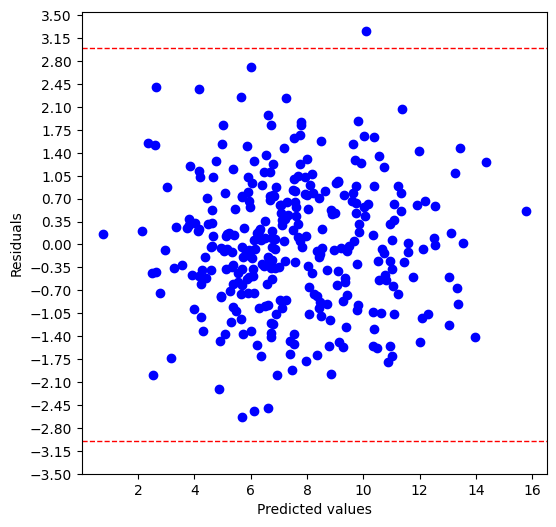

In [60]:
plt.figure(figsize=(6, 6))

predicted_bss = reg_out_cars_bss_training.predict(X_train_car[['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']])

plt.scatter(predicted_bss, residuals_bss_model, c='blue')

plt.yticks(np.linspace (-3.5, 3.5, 21))

plt.axhline(y=3, color='red', linestyle='--', linewidth=1)

plt.axhline(y=-3, color='red', linestyle='--', linewidth=1)

plt.ylabel("Residuals")

plt.xlabel("Predicted values")

plt.show()

I am curious about the following ...

The observation for the location where there was no sale (case with index = 174) was NOT an univariate outlier and is not showing up as multivariate outlier either. What's the standardized residual for the case with index = 174?

In [61]:
174 in standardized_residuals.index

False

In [62]:
174 in X_test_car.index


True

In [63]:
y_test_car.head(12)

,Sales
398,5.94
125,9.34
328,3.15
339,11.54
172,9.03
342,7.81
197,2.52
291,6.64
29,7.81
284,6.97


The issue is that the observation with index 174 is not in the training data. It was randomly chosen by the split function to be part of the test data.  It was not used to fit the equation. We will come back to this observation when analyzing the test data !

### Is the outlier and influential case?

Is the observation with index = 357 an influential case?

**SIMPLE WAY TO ADDRESS THIS QUESTION**: Repeat the analysis AFTER removing this observation and assess how much the coefficients and predictions change.

In [64]:
outlier_index= standardized_residuals[np.abs(standardized_residuals) > 3].index

In [65]:
outlier_index

Index([357], dtype='int64')

In [66]:
# Remove outlier from training data
X_train_no_outliers = X_train_bss.drop(index = outlier_index)
y_train_no_outliers = y_train_car.drop(index = outlier_index)

In [67]:
model_no_outliers = LinearRegression().fit(X_train_no_outliers, y_train_no_outliers)

Compare the coefficients from both models:

In [68]:
# Print coefficients

print("Original Model Coefficients:\n", reg_out_cars_bss_training.coef_)

print("Model Without Outliers Coefficients:\n", model_no_outliers.coef_)

Original Model Coefficients:
 [ 0.0925419   0.01445423  0.11626992 -0.09509037 -0.04916276  4.90376988
  2.04127126]
Model Without Outliers Coefficients:
 [ 0.09302707  0.01440153  0.11729276 -0.09433276 -0.04817412  4.89484175
  2.01749593]


Compare how much the predictions change after the removal.

We can do this in different ways. One simple way is to compute RSE for both models.

In [69]:
# RSE with outlier

rse_calculator (y_train_car, predicted_bss, X_train_bss.shape[1])

1.0052

In [70]:
# RSE without oulier

rse_calculator (y_train_no_outliers, model_no_outliers.predict(X_train_no_outliers[['CompPrice', 'Income', 'Advertising', 'Price', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Medium']]) , X_train_no_outliers.shape[1])

0.9893

In [71]:
# % decrease after removing outlier

((0.9893 - 1.0052)/1.0052)*100

-1.5817747711898262

Since removing the outlier does not change the prediction performance of the model that much (it only reduces the RSE by 1.58%), we could claim that the case with index = 357 is not an influential case. When an outlier is not found to be an influential case, the suggestion is not to worry about it and just keep the observation as part of the data.

If the outlier is found to an influential case, the analyst should investigate more about it.

Why is the case an outlier?
Why is the case an extreme case?

After this sort of analysis, the analyst decides whether to remove from the case or not.

#### Extra analysis

Does the observation representing no sales affect the test prediction performance of the chosen equation?

The test RMSE of the model chosen by bss is:

In [72]:
# Test RMSE (Test root MSE)

root_mean_squared_error(y_test_car, y_pred_cars_bss_test)

1.085291304831875

We get this test RMSE including observation with index= 174 (the one with Sales = 0)

Does any observation from the test data seem to be an outlier?

In [73]:
residuals_bss_test = y_test_car - y_pred_cars_bss_test

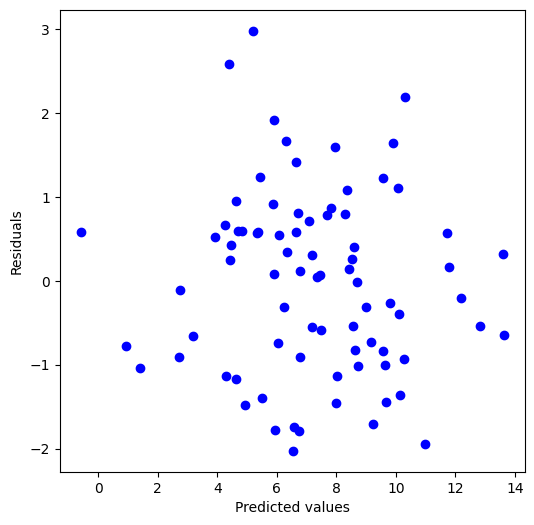

In [74]:
plt.figure(figsize=(6, 6))

plt.scatter(y_pred_cars_bss_test, residuals_bss_test , c='blue')

plt.ylabel("Residuals")

plt.xlabel("Predicted values")

plt.show()

In [75]:
residuals_bss_test [residuals_bss_test > 3]

,Sales


In [76]:
# Top largest positive residuals

residuals_bss_test.sort_values(ascending=False).head (5)

,Sales
207,2.979889
284,2.586269
171,2.189162
29,1.918323
41,1.664533


In [77]:
# Top largest negative residuals

residuals_bss_test.sort_values().head (5)

,Sales
92,-2.025319
172,-1.946290
382,-1.794971
4,-1.775496
214,-1.744045


What's the residual for observation with index= 174?

In [78]:
residuals_bss_test.loc[174]

0.5811193130588963

So, the location where there was no sales is not affecting the prediction performance on the test data.

Sales equals zero in this location because the values of the features in this location are conducive to low sales. In other words, given the values of the predictors for this location, sales =0 is NOT an expected result

In [79]:
# Values of the features for the location with no sales

carseats_df_dummies[carseats_df_dummies['Sales']==0][X_train_bss.columns]

,CompPrice,Income,Advertising,Price,Age,ShelveLoc_Good,ShelveLoc_Medium
174,139,24,0,185,79,0,1


In [80]:
for col in X_train_bss.columns:
  print (carseats_df_dummies[col].describe(),"\n")

count    400.000000
mean     124.975000
std       15.334512
min       77.000000
25%      115.000000
50%      125.000000
75%      135.000000
max      175.000000
Name: CompPrice, dtype: float64 

count    400.000000
mean      68.657500
std       27.986037
min       21.000000
25%       42.750000
50%       69.000000
75%       91.000000
max      120.000000
Name: Income, dtype: float64 

count    400.000000
mean       6.635000
std        6.650364
min        0.000000
25%        0.000000
50%        5.000000
75%       12.000000
max       29.000000
Name: Advertising, dtype: float64 

count    400.000000
mean     115.795000
std       23.676664
min       24.000000
25%      100.000000
50%      117.000000
75%      131.000000
max      191.000000
Name: Price, dtype: float64 

count    400.000000
mean      53.322500
std       16.200297
min       25.000000
25%       39.750000
50%       54.500000
75%       66.000000
max       80.000000
Name: Age, dtype: float64 

count    400.000000
mean       0.212500
s

**IGNORE**

I COMPUTED THIS RESIDUAL STEP BY STEP

In [81]:
y_test_car.loc[174]

0.0

In [82]:
position = y_test_car.index.get_loc(174)

In [83]:
predicted_value_174 = y_pred_cars_bss_test[position]

In [84]:
predicted_value_174

-0.5811193130588963

In [85]:
# Residual

0 - (-0.5811193130588963)

0.5811193130588963